In [ ]:
### 밑바닥부터 구현해보는 MLP전에 데이터셋 불러오기

#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-labels-idx1-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-labels-idx1-ubyte.gz  

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [9]:
### 압축 해제 코드
import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [ ]:
### 데이터 불러오는 함수 정의
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # gradient를 사용하기 때문에 픽셀 단위로 정규화를 해줌.
 
    return images, labels

In [13]:
### 데이터 불러오기

X_train, y_train = load_mnist('', kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

행: 60000, 열: 784
행: 10000, 열: 784


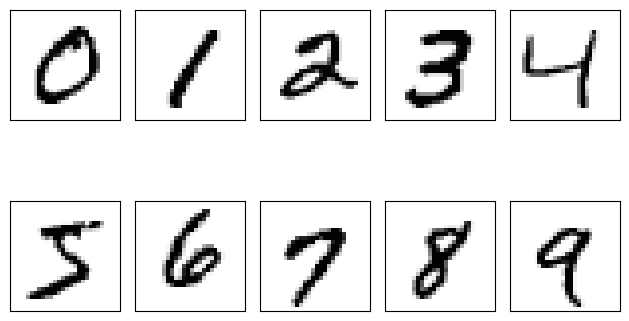

In [14]:
### 불러온 데이터 몇개만 출력해보기

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
### savez 함수를 이용해서 빠르게 데이터 불러오기

# savez 함수를 이용하면 데이터를 읽고 전처리하고, 불러오는 오버헤드를 줄일 수 있음.

import numpy as np

np.savez_compressed('mnist_scaled.npz',
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
mnist = np.load('mnist_scaled.npz')

In [ ]:
### 데이터 불러오기

X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files] # list comprehension으로 빠르게 데이터를 불러올수 있음.

In [ ]:
### 드디어 밑바닥부터 MLP를 구현해보기!

import numpy as np
import sys

class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self.random=np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs=epochs
        self.shuffle = shuffle
        self.eta = eta
        self.minibatch_size = minibatch_size
        
    def onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
            return onehot.T
        
    def sigmoid(self, z):
        # 값이 너무 작거나 크면 오버플로우가 발생하기 때문에 방지하기위해 -250~250 사이로 제한
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def forward(self, X):
        # 입력층에서 순전파 계산
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self.sigmoid(z_h)
        
        # 은닉층에서 순전파 계산
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self.sigmoid(z_out)
    
        return z_h, a_h, z_out, a_out
    
    def compute_cost(self, y_enc, output):
        # 은닉층 weight와 출력층 weight를 구한걸 바탕으로 L2항 계산
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        
        # 정답과 예측한값을 바탕으로 로지스틱 로스를 적용
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        
        # 최종적으로 term 1,2를 더해서 로스를 구함.
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self.forward(X) # 순전파를 통해서 각 층별로 계산된 값을 가져옴
        
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0] # 클래스의 개수 세기
        n_features = X_train.shape[1]
        
        self.b_h = np.zeros(self.n_hidden)
        # weight는 반드시 0으로 초기화 하면 안됨!
        # 0~1사이의 랜덤수로 초기화하는데, 사이즈는 (특성 개수 * 히든층 뉴런 개수)
        self.w_h = np.random.normal(loc=0, scale=0.1, size=(n_features, self.n_hidden)) 
        
        self.b_out = np.zeros(n_output)
        self.w_out = np.random.normal(loc=0, scale=0.1, size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs)) # 그냥 출력할때 포맷을 위해서 생성 (굳이 없어도됨)
        self.eval = {'cost' : [], 'train_acc' : [], 'valid_acc' : []}
        
        y_train_enc = self.onehot(y_train, n_output)
        
        # epoch 만큼 반복
        for i in range(self.epochs):
            
            # 미니 배치 단위로 반복
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            # 0번 부터 minibatch 단위로 끊어서 진행
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]
                
                # 순전파 계산
                z_h, a_h, z_out, a_out = self.forward(X_train[batch_idx])
                
                # 역전파 계산
                sigma_out = a_out - y_train_enc[batch_idx]
                sigmoid_derivate = a_h * (1. - a_h) # 시그모이드 미분하면 나오는 도함수
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivate)
                
                grad_w_h = np.dot(X_train[batch_idx.T], sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # l2규제 적용
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h
                
                self.w_h -= self.eta * delta_w_h # 가중치 업데이트
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = (grad_b_out)
                
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
            # 모델 평가
            
            z_h, a_h, z_out, a_out = self.forward(X_train)
            cost = self.compute_cost(y_enc=y_train_enc, output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self